# TrashID Milestone 7

Thomas Girmay


For this milestone, I have put together a notebook to show the current state of my code. I have managed to properly set up my environment, which includes the [Keras](https://keras.io/), [TensorFlow](https://www.tensorflow.org/install), [SciKit Learn](https://scikit-learn.org/stable/install.html), Numpy, and Shutil libraries. Keras and TensorFlow can be pip or conda installed to your system if you would like to run the code yourself.  Keras runs atop TensorFlow and helps make creating the convolutional neural network much more intuitive and easier. 

The goal for this milestone was to create a binary image classifier. I arbitrarily chose metal and plastic out of the groups contained in the dataset and I want to aim for above an 80% accuracy for the bare model. For the next milestone, I will fine-tune the model and hopefully attain above 90-95%. 

# Data Processing

The first cell of this notebook just imports all the libraries used throughout and is separated into the primary libraries used. The first cell also initializes an ImageDataGenerator object which I use to generate more data. Since I am working with relatively small [data](https://www.kaggle.com/katexu/trash_detection), I have decided to augment the images to prevent overfitting. This generator will shift, flip, rotate, rescale, zoom, and shear the images so that more will be generated and the model will generalize the data better. 

In [1]:

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Activation, Dropout, Flatten, Dense
import keras
keras.utils.np_utils.to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from keras.utils import to_categorical
import os
import numpy as np
import random
import shutil 
import tensorflow as tf


datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Using TensorFlow backend.


Here are some sample outputs of an item in the metal folder that was processed by the image generator:
<img align = "right" src=attachment:metal_0_86.jpg left width = 240> <img align = "right" src=attachment:metal_0_6893.jpg width = 240>
<img align = "right" src=attachment:metal_0_656.jpg right width = 240>
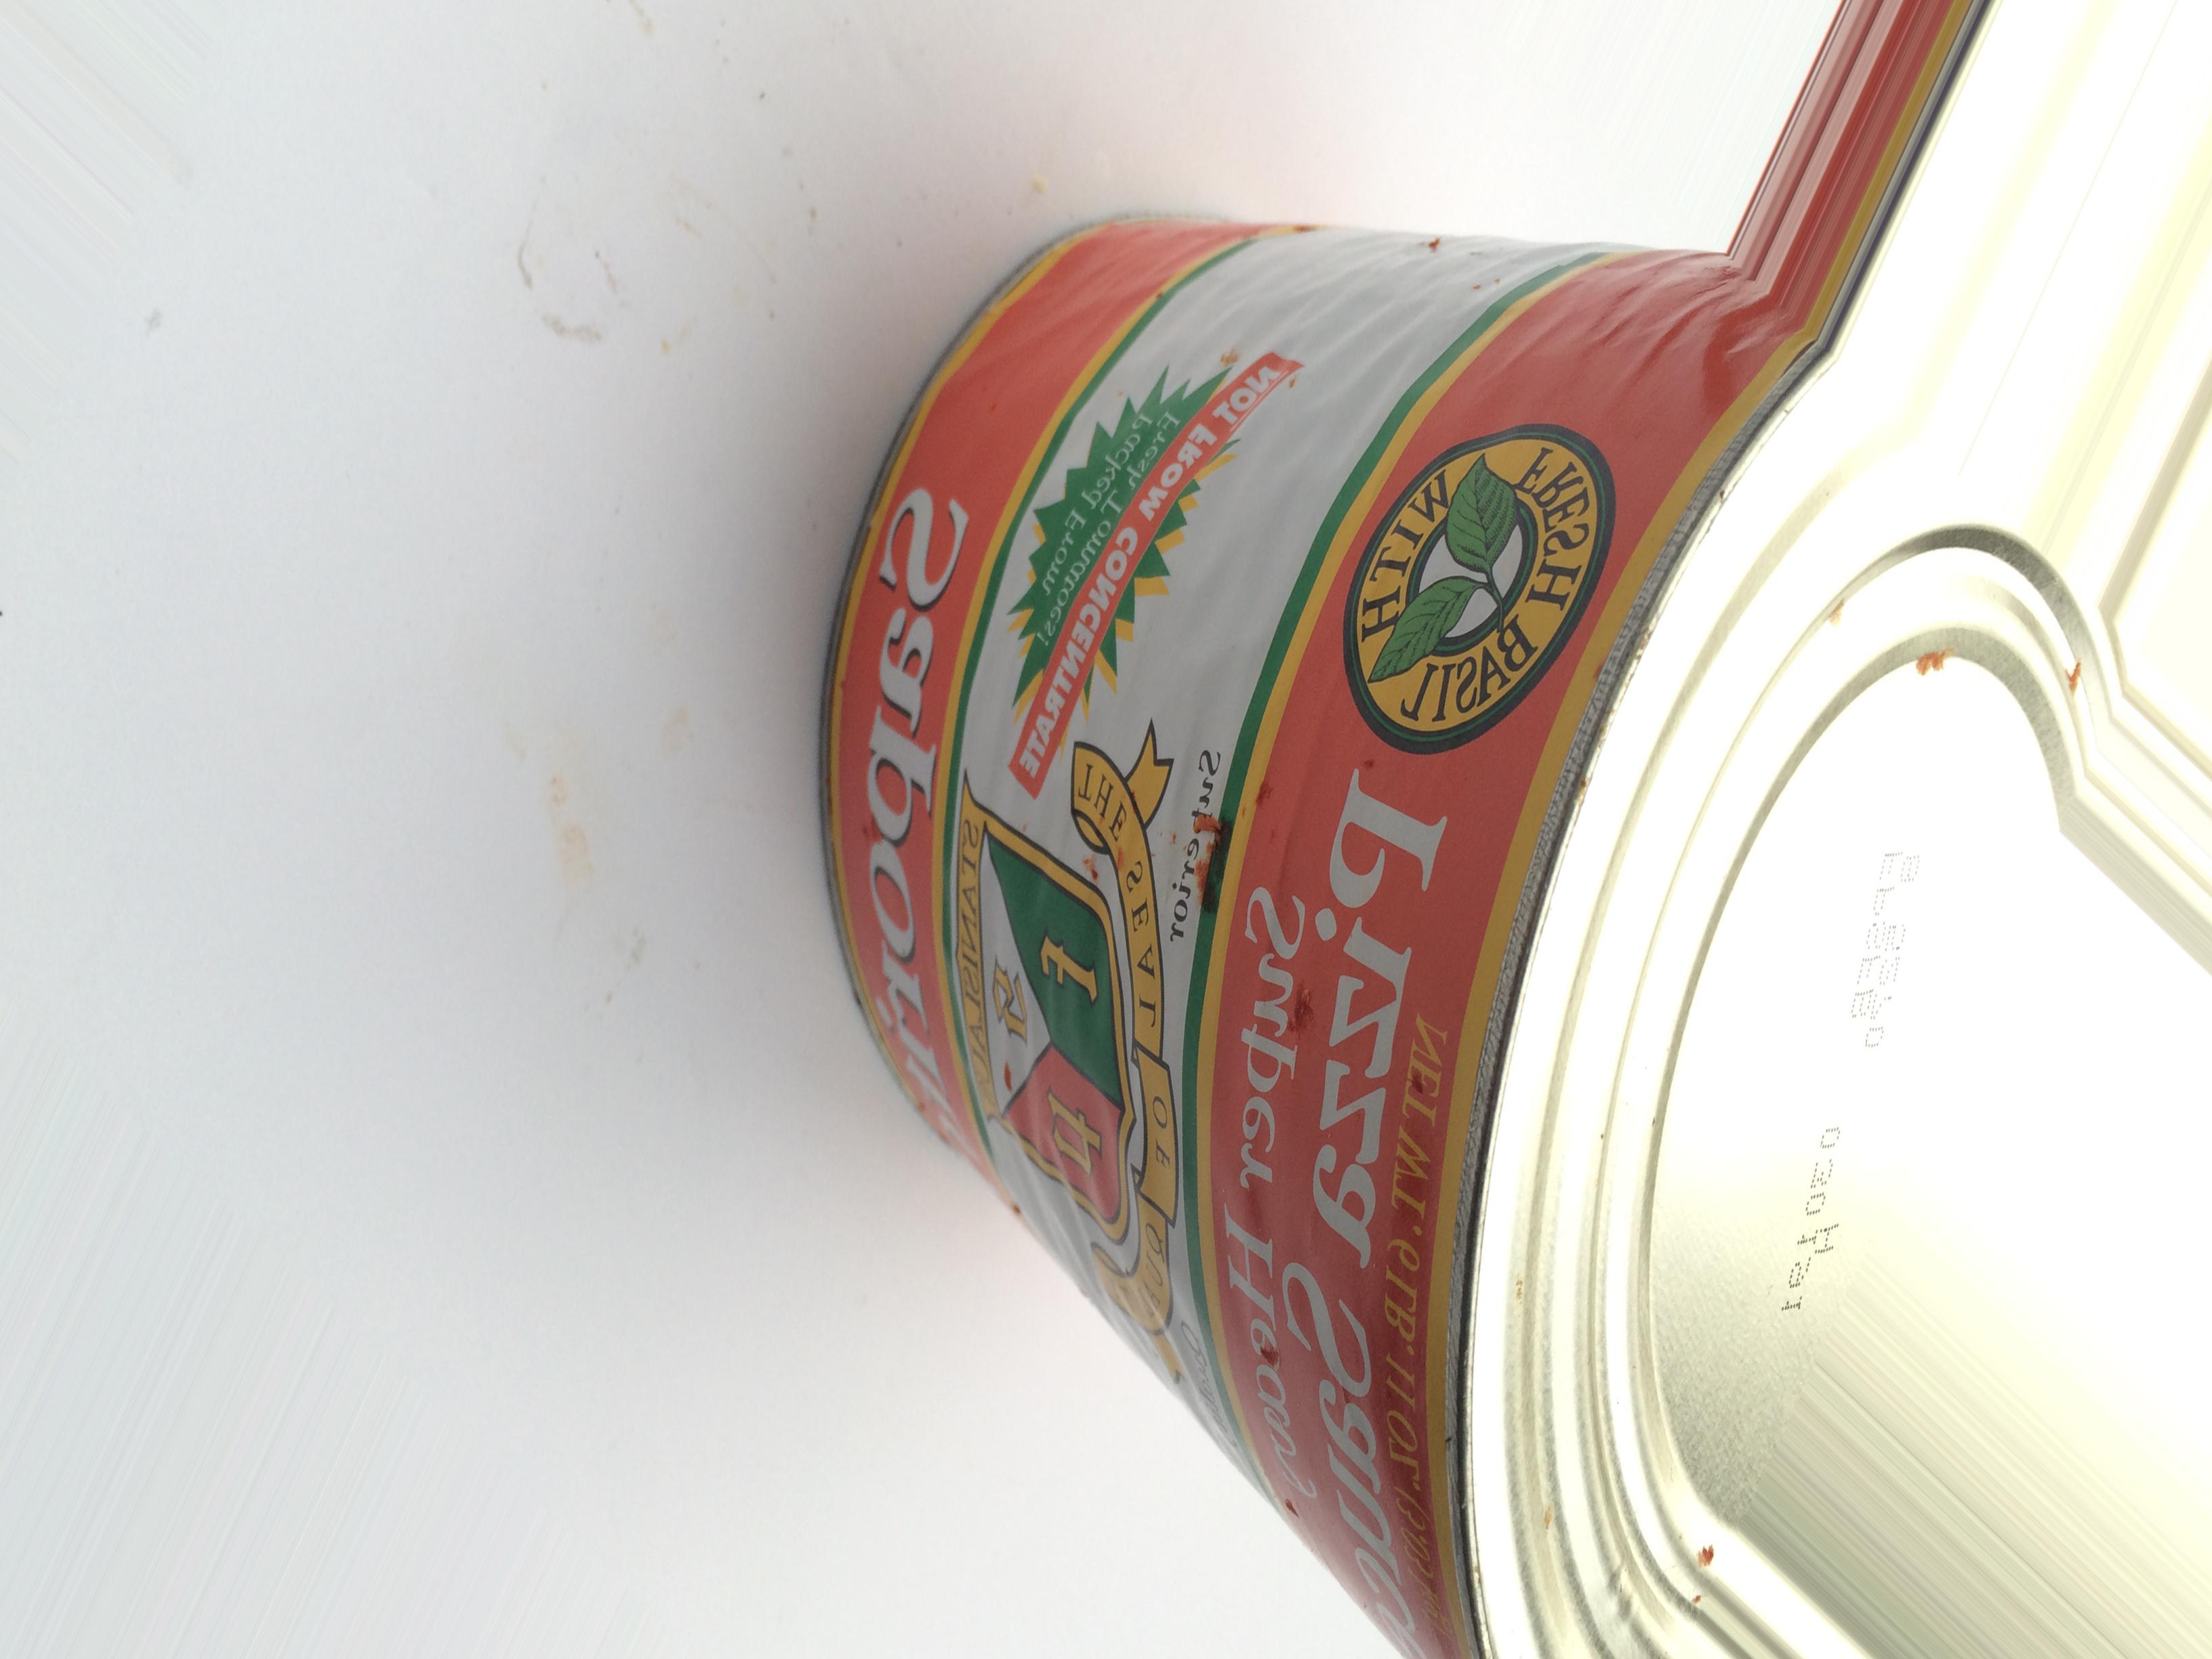
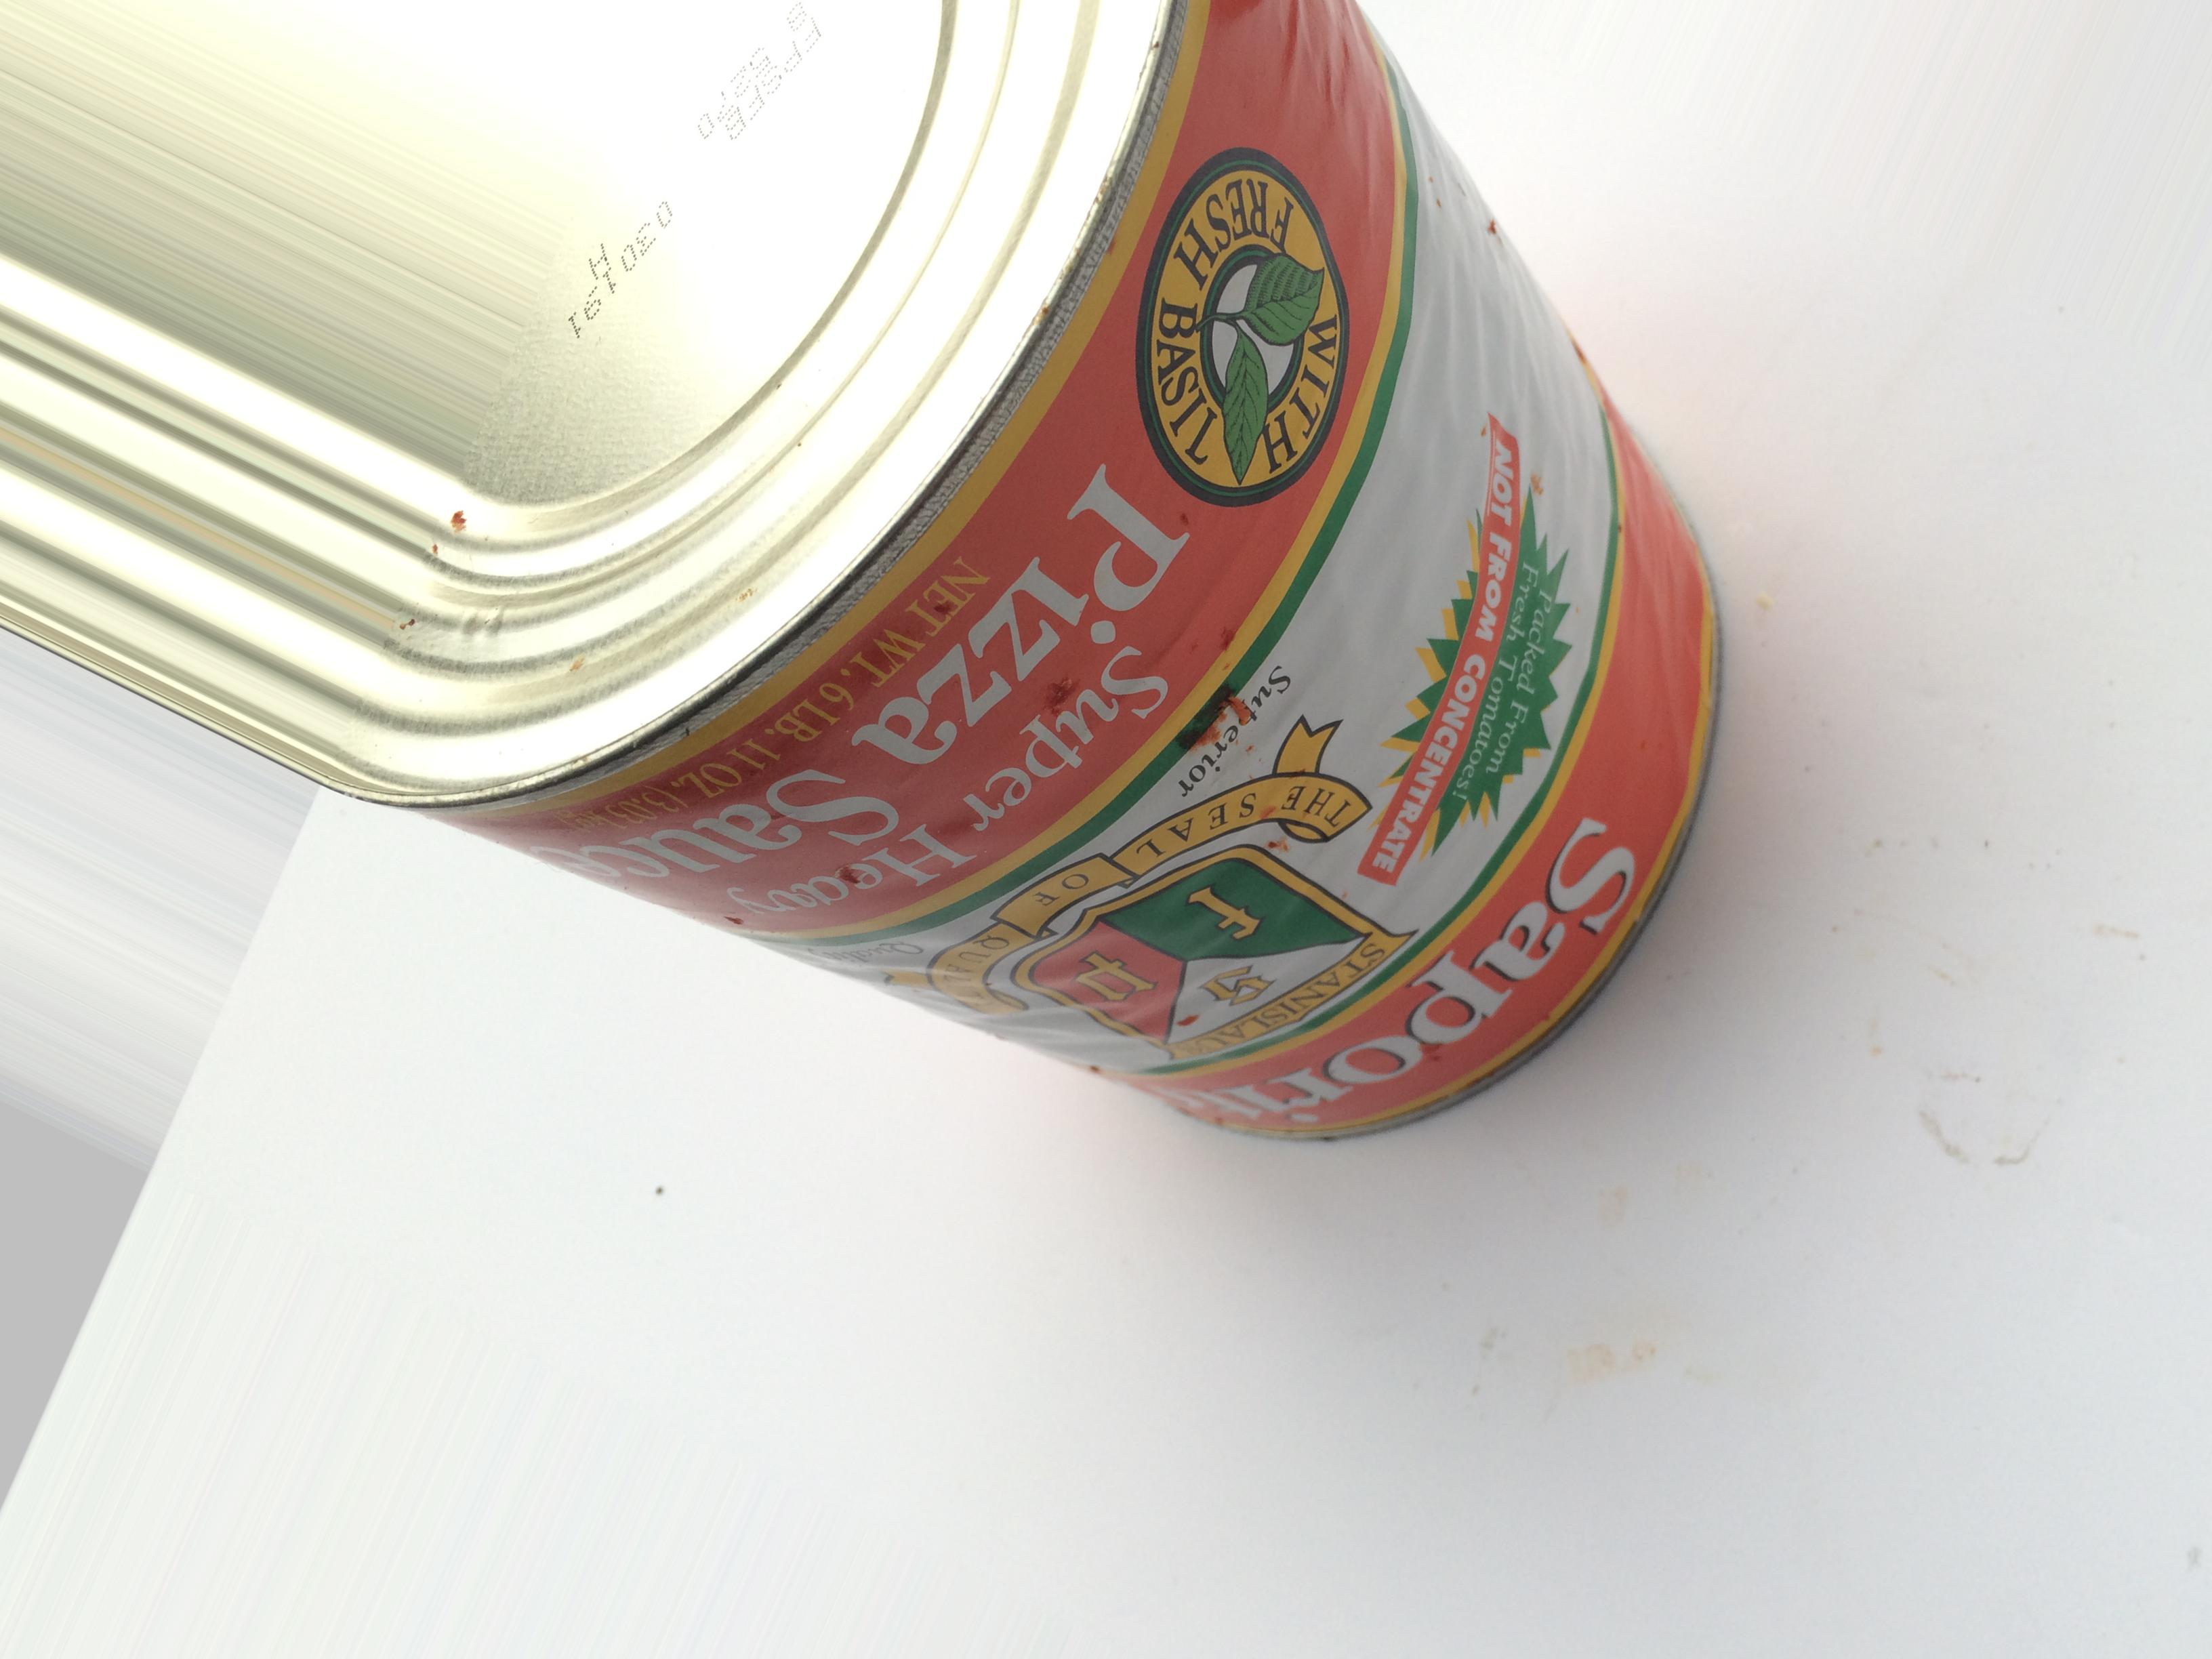
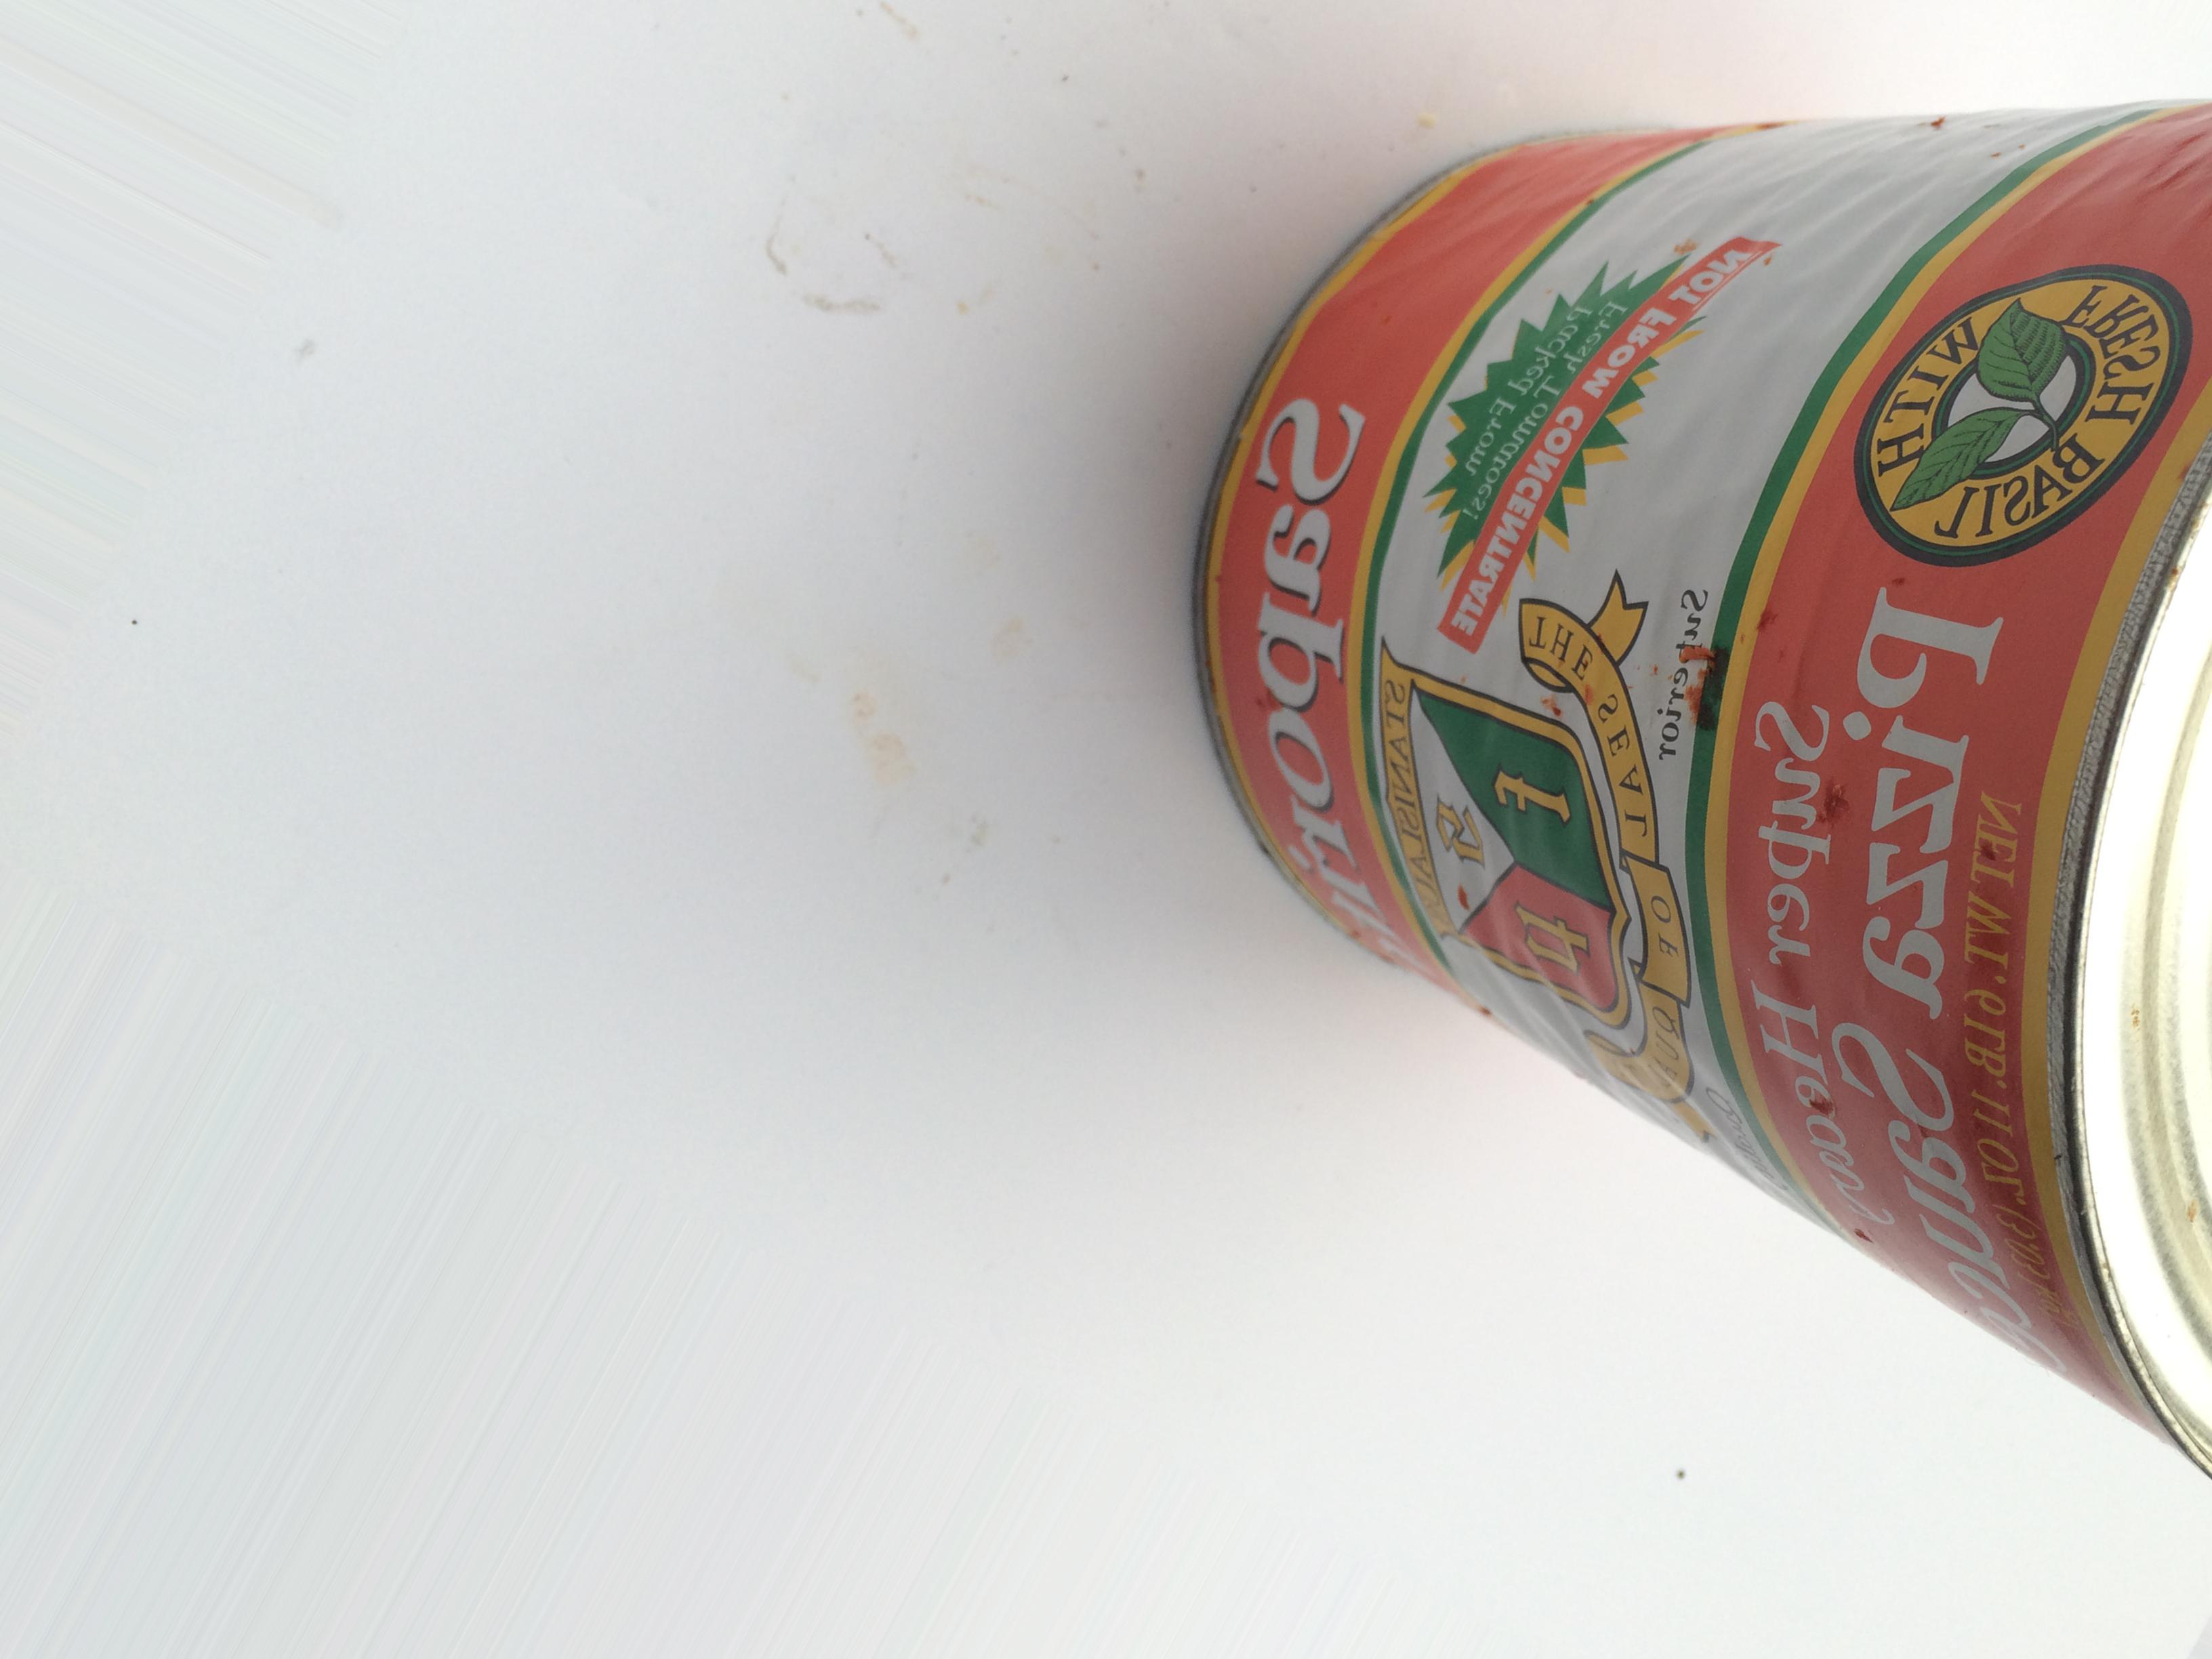

Next, I needed to split my dataset into three groups: one for training, one for testing, and one for validation. To accomplish this, I used some helper functions to split and move the data around. 

In [2]:



# splits indices for a folder into train, validation, and test indices with random sampling
# input: folder path
# output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

# gets file names for a particular type of trash, given indices
    # input: waste category and indices
    # output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+'_'+str(i)+".jpg" for i in indices]
    return(file_names)    

# moves group of source files to another folder
    # input: list of source files and destination folder
    # no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)


In [3]:

# paths will be train/metal, train/plastic, etc...
print('processing directories please wait...')
subsets = ['train','valid']
#onehot_waste_types = ['0','1','2','3','4','5']
onehot_waste_types=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
#one hot encoded for multi class classifer



## create destination folders for data subset and waste type
for subset in subsets:
    for onehot_waste_type in onehot_waste_types:
        folder = os.path.join('data',subset,onehot_waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
# move files to destination folders for each waste type

for onehot in onehot_waste_types:
    source_folder = os.path.join('trash_dataset',onehot)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    # move source files to train
    train_names = get_names(onehot,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+ onehot 
    move_files(train_source_files,train_dest)
    
    # move source files to valid
    valid_names = get_names(onehot,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+ onehot
    move_files(valid_source_files,valid_dest)
    
    # move source files to test
    test_names = get_names(onehot,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    
    move_files(test_source_files,"data/test")

print('done')

processing directories please wait...
done


# Creating The Model

In editing my model to accomodate more than two classes, I had to alter the structure. Now there are 6 maxpool layers (convolutions), followed by two dense layers. I used a relu activations for the layers and softmax for the output.

In [4]:
model = keras.models.Sequential([
    #  input shape is the desired size of the image 150x 150 with 3 bytes color
    # The first convolution
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150,3)),
    keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The third convolution
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    keras.layers.Dense(128, activation='relu'),
    # 6 output neurons for 6 classes with the softmax activation
    keras.layers.Dense(6, activation='softmax')
])
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [5]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)       

# Training the Model

Now that the model structure has been set up and the data is processed, I need to set up how the model will learn this task. It will basically take data from the respective folder and apply another image gen effect to it so that it can maximize its generalization efficacy. 

In [6]:
batch_size = 16

# this is the augmentation configuration for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
        class_mode='categorical')  

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(150, 150),
        batch_size=batch_size,
        classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
        class_mode='categorical')

Found 1262 images belonging to 6 classes.
Found 629 images belonging to 6 classes.


Here, the setup created in the cell above is fit to the generator and the model is set to learn. I am currently tweaking the number of epochs. For the purposes of this notebook and milestone submission, I set the epochs to 1. As of now, at 50 epochs I have attained a 81% accuracy with the bare model. Here is a sample output from that run:


Epoch 50/50 125/125 [==============================] - 346s 3s/step - loss: 0.1586 - accuracy: 0.9739 - val_loss: 1.6151 - **val_accuracy: 0.8149**


In [7]:
 model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('weightsFull.h5')  # save weights 

Epoch 1/1000
 25/125 [=====>........................] - ETA: 25s - loss: 1.7476 - accuracy: 0.1850

KeyboardInterrupt: 

In [9]:
from keras.preprocessing import image

def decode(data):
    onehot_waste_types = [ 'glass', 'metal', 'paper', 'plastic', 'trash','cardboard']
    return onehot_waste_types[np.argmax(data)]

test_img = image.load_img("data/test/metal_384.jpg", target_size = (150,150))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis = 0)

pred = decode(model.predict(test_img))
pred

'plastic'

# The GUI


In [10]:
 sudo apt-get install python3-pyqt5

SyntaxError: invalid syntax (<ipython-input-10-b31da34c7313>, line 1)

# Next Steps

I have sped up the epoch speed and implemented all classes in the classifier. The last thing I need to do is make a GUI for the SSE Expo.
